Summer 2021 mta_data analysis and where I learned.

Import sqlalchemy and pandas.

In [66]:
from sqlalchemy import create_engine
from sqlalchemy import inspect
import datetime
import pandas as pd

List the table names in the database.

In [67]:
engine = create_engine("sqlite:///mta.db")
insp = inspect(engine)
print(insp.get_table_names())

['mta_data']


Import mta.db into python to clean with SQLAlchemy. Remove LINENAME, DIVISION which are not needed.

In [68]:
mta_df_all = pd.read_sql('SELECT CA, UNIT, SCP, STATION, DATE, TIME, DESC, ENTRIES, EXITS, DATE_TIME FROM mta_data;', engine)
mta_df_all

,CA,UNIT,SCP,STATION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
0,A002,R051,02-00-00,59 ST,08/28/2021,00:00:00,REGULAR,7625998,2609113,2021-08-28 00:00:00
1,A002,R051,02-00-00,59 ST,08/28/2021,04:00:00,REGULAR,7626014,2609117,2021-08-28 04:00:00
2,A002,R051,02-00-00,59 ST,08/28/2021,08:00:00,REGULAR,7626024,2609135,2021-08-28 08:00:00
3,A002,R051,02-00-00,59 ST,08/28/2021,12:00:00,REGULAR,7626086,2609191,2021-08-28 12:00:00
4,A002,R051,02-00-00,59 ST,08/28/2021,16:00:00,REGULAR,7626206,2609221,2021-08-28 16:00:00
...,...,...,...,...,...,...,...,...,...,...
2932340,TRAM2,R469,00-05-01,RIT-ROOSEVELT,06/04/2021,05:00:00,REGULAR,5554,577,2021-06-04 05:00:00
2932341,TRAM2,R469,00-05-01,RIT-ROOSEVELT,06/04/2021,09:00:00,REGULAR,5554,577,2021-06-04 09:00:00
2932342,TRAM2,R469,00-05-01,RIT-ROOSEVELT,06/04/2021,13:00:00,REGULAR,5554,577,2021-06-04 13:00:00
2932343,TRAM2,R469,00-05-01,RIT-ROOSEVELT,06/04/2021,17:00:00,REGULAR,5554,577,2021-06-04 17:00:00


Review the unique STATION identifiers without turnstile detail or unit-C/A which implies entrance / exit location.

In [69]:
station_data = pd.read_sql('SELECT STATION FROM mta_data GROUP BY STATION;', engine)
station_data

,STATION
0,1 AV
1,103 ST
2,103 ST-CORONA
3,104 ST
4,110 ST
...,...
374,WOODLAWN
375,WORLD TRADE CTR
376,WTC-CORTLANDT
377,YORK ST


Clean headers. No padding found.

In [70]:
mta_df_all.columns

Index(['CA', 'UNIT', 'SCP', 'STATION', 'DATE', 'TIME', 'DESC', 'ENTRIES',
       'EXITS', 'DATE_TIME'],
      dtype='object')

Eliminate null rows. No null rows found.

In [71]:
pd.read_sql('SELECT * FROM mta_data WHERE (STATION OR CA OR UNIT OR SCP) IS NULL;', engine)

,CA,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME


In [72]:
mta_df_all.isna().sum()


CA           0
UNIT         0
SCP          0
STATION      0
DATE         0
TIME         0
DESC         0
ENTRIES      0
EXITS        0
DATE_TIME    0
dtype: int64

** RETURN TO THIS ** Review the date information, remove all but Jun, Jul, Aug.

In [73]:
mta_df_all.DATE_TIME.value_counts().sort_index()

2021-05-29 00:00:00    2558
2021-05-29 00:01:09       1
2021-05-29 00:01:57       1
2021-05-29 00:02:56       1
2021-05-29 00:04:06       1
                       ... 
2021-09-03 23:57:02       1
2021-09-03 23:57:08       1
2021-09-03 23:58:47       1
2021-09-03 23:59:08       1
2021-09-03 23:59:56       1
Name: DATE_TIME, Length: 184960, dtype: int64

In [74]:
pd.to_datetime(mta_df_all['DATE_TIME'])

0         2021-08-28 00:00:00
1         2021-08-28 04:00:00
2         2021-08-28 08:00:00
3         2021-08-28 12:00:00
4         2021-08-28 16:00:00
                  ...        
2932340   2021-06-04 05:00:00
2932341   2021-06-04 09:00:00
2932342   2021-06-04 13:00:00
2932343   2021-06-04 17:00:00
2932344   2021-06-04 21:00:00
Name: DATE_TIME, Length: 2932345, dtype: datetime64[ns]

In [75]:
sep = pd.to_datetime('09/01/2021', format = '%m/%d/%Y')
may = pd.to_datetime('05/31/2021', format = '%m/%d/%Y')
print(sep, may)

2021-09-01 00:00:00 2021-05-31 00:00:00


Check for ENTRIES / EXITS much different than the others at the same turnstile.

Drop Audit records.

In [76]:
mask2 = mta_df_all['DESC'] == 'REGULAR'
mta_df_all = mta_df_all[mask2]
mta_df_all

,CA,UNIT,SCP,STATION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
0,A002,R051,02-00-00,59 ST,08/28/2021,00:00:00,REGULAR,7625998,2609113,2021-08-28 00:00:00
1,A002,R051,02-00-00,59 ST,08/28/2021,04:00:00,REGULAR,7626014,2609117,2021-08-28 04:00:00
2,A002,R051,02-00-00,59 ST,08/28/2021,08:00:00,REGULAR,7626024,2609135,2021-08-28 08:00:00
3,A002,R051,02-00-00,59 ST,08/28/2021,12:00:00,REGULAR,7626086,2609191,2021-08-28 12:00:00
4,A002,R051,02-00-00,59 ST,08/28/2021,16:00:00,REGULAR,7626206,2609221,2021-08-28 16:00:00
...,...,...,...,...,...,...,...,...,...,...
2932340,TRAM2,R469,00-05-01,RIT-ROOSEVELT,06/04/2021,05:00:00,REGULAR,5554,577,2021-06-04 05:00:00
2932341,TRAM2,R469,00-05-01,RIT-ROOSEVELT,06/04/2021,09:00:00,REGULAR,5554,577,2021-06-04 09:00:00
2932342,TRAM2,R469,00-05-01,RIT-ROOSEVELT,06/04/2021,13:00:00,REGULAR,5554,577,2021-06-04 13:00:00
2932343,TRAM2,R469,00-05-01,RIT-ROOSEVELT,06/04/2021,17:00:00,REGULAR,5554,577,2021-06-04 17:00:00


Tag each row with the mean / std ENTRIES and EXITS for the DATE.

In [77]:
mta_df_all['MEAN_ENT'] = mta_df_all.groupby(['CA','UNIT','SCP','STATION']).ENTRIES.transform('mean') 
mta_df_all['MEAN_EXT'] = mta_df_all.groupby(['CA','UNIT','SCP','STATION']).EXITS.transform('mean') 
mta_df_all['STD_ENT'] = mta_df_all.groupby(['CA','UNIT','SCP','STATION']).ENTRIES.transform('std') 
mta_df_all['STD_EXT'] = mta_df_all.groupby(['CA','UNIT','SCP','STATION']).EXITS.transform('std') 
mta_df_all


/var/folders/_m/dftsz8r12_g4207dhmcv4ynm0000gn/T/ipykernel_1627/1246769272.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mta_df_all['MEAN_ENT'] = mta_df_all.groupby(['CA','UNIT','SCP','STATION']).ENTRIES.transform('mean')
/var/folders/_m/dftsz8r12_g4207dhmcv4ynm0000gn/T/ipykernel_1627/1246769272.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mta_df_all['MEAN_EXT'] = mta_df_all.groupby(['CA','UNIT','SCP','STATION']).EXITS.transform('mean')
/var/folders/_m/dftsz8r12_g4207dhmcv4ynm0000gn/T/ipykernel

,CA,UNIT,SCP,STATION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,MEAN_ENT,MEAN_EXT,STD_ENT,STD_EXT
0,A002,R051,02-00-00,59 ST,08/28/2021,00:00:00,REGULAR,7625998,2609113,2021-08-28 00:00:00,7.603646e+06,2.600164e+06,14871.399859,5942.147473
1,A002,R051,02-00-00,59 ST,08/28/2021,04:00:00,REGULAR,7626014,2609117,2021-08-28 04:00:00,7.603646e+06,2.600164e+06,14871.399859,5942.147473
2,A002,R051,02-00-00,59 ST,08/28/2021,08:00:00,REGULAR,7626024,2609135,2021-08-28 08:00:00,7.603646e+06,2.600164e+06,14871.399859,5942.147473
3,A002,R051,02-00-00,59 ST,08/28/2021,12:00:00,REGULAR,7626086,2609191,2021-08-28 12:00:00,7.603646e+06,2.600164e+06,14871.399859,5942.147473
4,A002,R051,02-00-00,59 ST,08/28/2021,16:00:00,REGULAR,7626206,2609221,2021-08-28 16:00:00,7.603646e+06,2.600164e+06,14871.399859,5942.147473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2932340,TRAM2,R469,00-05-01,RIT-ROOSEVELT,06/04/2021,05:00:00,REGULAR,5554,577,2021-06-04 05:00:00,5.554000e+03,5.922606e+02,0.000000,13.640570
2932341,TRAM2,R469,00-05-01,RIT-ROOSEVELT,06/04/2021,09:00:00,REGULAR,5554,577,2021-06-04 09:00:00,5.554000e+03,5.922606e+02,0.000000,13.640570
2932342,TRAM2,R469,00-05-01,RIT-ROOSEVELT,06/04/2021,13:00:00,REGULAR,5554,577,2021-06-04 13:00:00,5.554000e+03,5.922606e+02,0.000000,13.640570
2932343,TRAM2,R469,00-05-01,RIT-ROOSEVELT,06/04/2021,17:00:00,REGULAR,5554,577,2021-06-04 17:00:00,5.554000e+03,5.922606e+02,0.000000,13.640570


Drop rows not within a std.

In [78]:
mask = mta_df_all['ENTRIES'] < (mta_df_all['MEAN_ENT'] + mta_df_all['STD_ENT'])
mta_df_clean = mta_df_all[mask]
mta_df_clean

,CA,UNIT,SCP,STATION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,MEAN_ENT,MEAN_EXT,STD_ENT,STD_EXT
840,A007,R079,01-05-00,5 AV/59 ST,08/28/2021,02:00:00,REGULAR,3683,0,2021-08-28 02:00:00,3680.114923,0.0,3.427025,0.0
841,A007,R079,01-05-00,5 AV/59 ST,08/28/2021,06:00:00,REGULAR,3683,0,2021-08-28 06:00:00,3680.114923,0.0,3.427025,0.0
842,A007,R079,01-05-00,5 AV/59 ST,08/28/2021,10:00:00,REGULAR,3683,0,2021-08-28 10:00:00,3680.114923,0.0,3.427025,0.0
843,A007,R079,01-05-00,5 AV/59 ST,08/28/2021,14:00:00,REGULAR,3683,0,2021-08-28 14:00:00,3680.114923,0.0,3.427025,0.0
844,A007,R079,01-05-00,5 AV/59 ST,08/28/2021,18:00:00,REGULAR,3683,0,2021-08-28 18:00:00,3680.114923,0.0,3.427025,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2932298,TRAM2,R469,00-05-00,RIT-ROOSEVELT,06/04/2021,05:00:00,REGULAR,0,0,2021-06-04 05:00:00,0.151142,0.0,0.358503,0.0
2932299,TRAM2,R469,00-05-00,RIT-ROOSEVELT,06/04/2021,09:00:00,REGULAR,0,0,2021-06-04 09:00:00,0.151142,0.0,0.358503,0.0
2932300,TRAM2,R469,00-05-00,RIT-ROOSEVELT,06/04/2021,13:00:00,REGULAR,0,0,2021-06-04 13:00:00,0.151142,0.0,0.358503,0.0
2932301,TRAM2,R469,00-05-00,RIT-ROOSEVELT,06/04/2021,17:00:00,REGULAR,0,0,2021-06-04 17:00:00,0.151142,0.0,0.358503,0.0


In [79]:
mask = mta_df_all['ENTRIES'] > (mta_df_all['MEAN_ENT'] - mta_df_all['STD_ENT'])
mta_df_clean = mta_df_clean[mask]
mta_df_clean

/var/folders/_m/dftsz8r12_g4207dhmcv4ynm0000gn/T/ipykernel_1627/1427781087.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mta_df_clean = mta_df_clean[mask]


,CA,UNIT,SCP,STATION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,MEAN_ENT,MEAN_EXT,STD_ENT,STD_EXT
840,A007,R079,01-05-00,5 AV/59 ST,08/28/2021,02:00:00,REGULAR,3683,0,2021-08-28 02:00:00,3680.114923,0.0,3.427025,0.0
841,A007,R079,01-05-00,5 AV/59 ST,08/28/2021,06:00:00,REGULAR,3683,0,2021-08-28 06:00:00,3680.114923,0.0,3.427025,0.0
842,A007,R079,01-05-00,5 AV/59 ST,08/28/2021,10:00:00,REGULAR,3683,0,2021-08-28 10:00:00,3680.114923,0.0,3.427025,0.0
843,A007,R079,01-05-00,5 AV/59 ST,08/28/2021,14:00:00,REGULAR,3683,0,2021-08-28 14:00:00,3680.114923,0.0,3.427025,0.0
844,A007,R079,01-05-00,5 AV/59 ST,08/28/2021,18:00:00,REGULAR,3683,0,2021-08-28 18:00:00,3680.114923,0.0,3.427025,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2932298,TRAM2,R469,00-05-00,RIT-ROOSEVELT,06/04/2021,05:00:00,REGULAR,0,0,2021-06-04 05:00:00,0.151142,0.0,0.358503,0.0
2932299,TRAM2,R469,00-05-00,RIT-ROOSEVELT,06/04/2021,09:00:00,REGULAR,0,0,2021-06-04 09:00:00,0.151142,0.0,0.358503,0.0
2932300,TRAM2,R469,00-05-00,RIT-ROOSEVELT,06/04/2021,13:00:00,REGULAR,0,0,2021-06-04 13:00:00,0.151142,0.0,0.358503,0.0
2932301,TRAM2,R469,00-05-00,RIT-ROOSEVELT,06/04/2021,17:00:00,REGULAR,0,0,2021-06-04 17:00:00,0.151142,0.0,0.358503,0.0


In [80]:
mask = mta_df_all['EXITS'] < (mta_df_all['MEAN_EXT'] + mta_df_all['STD_EXT'])
mta_df_clean = mta_df_clean[mask]
mta_df_clean

/var/folders/_m/dftsz8r12_g4207dhmcv4ynm0000gn/T/ipykernel_1627/836339281.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mta_df_clean = mta_df_clean[mask]


,CA,UNIT,SCP,STATION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,MEAN_ENT,MEAN_EXT,STD_ENT,STD_EXT
2310,A014,R081,02-00-00,49 ST,08/28/2021,00:00:00,REGULAR,22717,12322,2021-08-28 00:00:00,3.298980e+04,16761.727915,23576.147943,11668.355087
2311,A014,R081,02-00-00,49 ST,08/28/2021,04:00:00,REGULAR,22748,12331,2021-08-28 04:00:00,3.298980e+04,16761.727915,23576.147943,11668.355087
2312,A014,R081,02-00-00,49 ST,08/28/2021,08:00:00,REGULAR,22762,12354,2021-08-28 08:00:00,3.298980e+04,16761.727915,23576.147943,11668.355087
2313,A014,R081,02-00-00,49 ST,08/28/2021,12:00:00,REGULAR,22799,12384,2021-08-28 12:00:00,3.298980e+04,16761.727915,23576.147943,11668.355087
2314,A014,R081,02-00-00,49 ST,08/28/2021,16:00:00,REGULAR,22882,12430,2021-08-28 16:00:00,3.298980e+04,16761.727915,23576.147943,11668.355087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2932256,TRAM2,R469,00-03-01,RIT-ROOSEVELT,06/04/2021,05:00:00,REGULAR,3133585,397464,2021-06-04 05:00:00,3.136768e+06,397663.848858,3227.498961,210.059226
2932257,TRAM2,R469,00-03-01,RIT-ROOSEVELT,06/04/2021,09:00:00,REGULAR,3133585,397464,2021-06-04 09:00:00,3.136768e+06,397663.848858,3227.498961,210.059226
2932258,TRAM2,R469,00-03-01,RIT-ROOSEVELT,06/04/2021,13:00:00,REGULAR,3133585,397464,2021-06-04 13:00:00,3.136768e+06,397663.848858,3227.498961,210.059226
2932259,TRAM2,R469,00-03-01,RIT-ROOSEVELT,06/04/2021,17:00:00,REGULAR,3133585,397464,2021-06-04 17:00:00,3.136768e+06,397663.848858,3227.498961,210.059226


In [81]:
mask = mta_df_all['EXITS'] > (mta_df_all['MEAN_EXT'] - mta_df_all['STD_EXT'])
mta_df_clean = mta_df_clean[mask]
mta_df_clean

/var/folders/_m/dftsz8r12_g4207dhmcv4ynm0000gn/T/ipykernel_1627/3201942341.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mta_df_clean = mta_df_clean[mask]


,CA,UNIT,SCP,STATION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,MEAN_ENT,MEAN_EXT,STD_ENT,STD_EXT
2310,A014,R081,02-00-00,49 ST,08/28/2021,00:00:00,REGULAR,22717,12322,2021-08-28 00:00:00,3.298980e+04,16761.727915,23576.147943,11668.355087
2311,A014,R081,02-00-00,49 ST,08/28/2021,04:00:00,REGULAR,22748,12331,2021-08-28 04:00:00,3.298980e+04,16761.727915,23576.147943,11668.355087
2312,A014,R081,02-00-00,49 ST,08/28/2021,08:00:00,REGULAR,22762,12354,2021-08-28 08:00:00,3.298980e+04,16761.727915,23576.147943,11668.355087
2313,A014,R081,02-00-00,49 ST,08/28/2021,12:00:00,REGULAR,22799,12384,2021-08-28 12:00:00,3.298980e+04,16761.727915,23576.147943,11668.355087
2314,A014,R081,02-00-00,49 ST,08/28/2021,16:00:00,REGULAR,22882,12430,2021-08-28 16:00:00,3.298980e+04,16761.727915,23576.147943,11668.355087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2932256,TRAM2,R469,00-03-01,RIT-ROOSEVELT,06/04/2021,05:00:00,REGULAR,3133585,397464,2021-06-04 05:00:00,3.136768e+06,397663.848858,3227.498961,210.059226
2932257,TRAM2,R469,00-03-01,RIT-ROOSEVELT,06/04/2021,09:00:00,REGULAR,3133585,397464,2021-06-04 09:00:00,3.136768e+06,397663.848858,3227.498961,210.059226
2932258,TRAM2,R469,00-03-01,RIT-ROOSEVELT,06/04/2021,13:00:00,REGULAR,3133585,397464,2021-06-04 13:00:00,3.136768e+06,397663.848858,3227.498961,210.059226
2932259,TRAM2,R469,00-03-01,RIT-ROOSEVELT,06/04/2021,17:00:00,REGULAR,3133585,397464,2021-06-04 17:00:00,3.136768e+06,397663.848858,3227.498961,210.059226


In [82]:
mta_df_clean.shape

(1507670, 14)

In [83]:
clean = [923268,
1585284,
1585285,
1585286,
966456,
966457,
2463902,
2463903,
1625795,
1625796,
1625797]
for c in clean:
    mta_df_clean.drop([c], inplace=True)
mta_df_clean.shape

/Applications/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


(1507659, 14)

Find the min Entries / Exits for the day.

In [84]:
mta_df_clean['MIN_ENT'] = mta_df_clean.groupby(['CA','UNIT','SCP','STATION','DATE']).ENTRIES.transform('min') 
mta_df_clean['MIN_EXT'] = mta_df_clean.groupby(['CA','UNIT','SCP','STATION','DATE']).EXITS.transform('min') 
mta_df_clean

/var/folders/_m/dftsz8r12_g4207dhmcv4ynm0000gn/T/ipykernel_1627/4183349431.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mta_df_clean['MIN_ENT'] = mta_df_clean.groupby(['CA','UNIT','SCP','STATION','DATE']).ENTRIES.transform('min')
/var/folders/_m/dftsz8r12_g4207dhmcv4ynm0000gn/T/ipykernel_1627/4183349431.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mta_df_clean['MIN_EXT'] = mta_df_clean.groupby(['CA','UNIT','SCP','STATION','DATE']).EXITS.transform('min')


,CA,UNIT,SCP,STATION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,MEAN_ENT,MEAN_EXT,STD_ENT,STD_EXT,MIN_ENT,MIN_EXT
2310,A014,R081,02-00-00,49 ST,08/28/2021,00:00:00,REGULAR,22717,12322,2021-08-28 00:00:00,3.298980e+04,16761.727915,23576.147943,11668.355087,22717,12322
2311,A014,R081,02-00-00,49 ST,08/28/2021,04:00:00,REGULAR,22748,12331,2021-08-28 04:00:00,3.298980e+04,16761.727915,23576.147943,11668.355087,22717,12322
2312,A014,R081,02-00-00,49 ST,08/28/2021,08:00:00,REGULAR,22762,12354,2021-08-28 08:00:00,3.298980e+04,16761.727915,23576.147943,11668.355087,22717,12322
2313,A014,R081,02-00-00,49 ST,08/28/2021,12:00:00,REGULAR,22799,12384,2021-08-28 12:00:00,3.298980e+04,16761.727915,23576.147943,11668.355087,22717,12322
2314,A014,R081,02-00-00,49 ST,08/28/2021,16:00:00,REGULAR,22882,12430,2021-08-28 16:00:00,3.298980e+04,16761.727915,23576.147943,11668.355087,22717,12322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2932256,TRAM2,R469,00-03-01,RIT-ROOSEVELT,06/04/2021,05:00:00,REGULAR,3133585,397464,2021-06-04 05:00:00,3.136768e+06,397663.848858,3227.498961,210.059226,3133585,397464
2932257,TRAM2,R469,00-03-01,RIT-ROOSEVELT,06/04/2021,09:00:00,REGULAR,3133585,397464,2021-06-04 09:00:00,3.136768e+06,397663.848858,3227.498961,210.059226,3133585,397464
2932258,TRAM2,R469,00-03-01,RIT-ROOSEVELT,06/04/2021,13:00:00,REGULAR,3133585,397464,2021-06-04 13:00:00,3.136768e+06,397663.848858,3227.498961,210.059226,3133585,397464
2932259,TRAM2,R469,00-03-01,RIT-ROOSEVELT,06/04/2021,17:00:00,REGULAR,3133585,397464,2021-06-04 17:00:00,3.136768e+06,397663.848858,3227.498961,210.059226,3133585,397464


Subtract min Entries / Exits from Entries / Exits to get the amount each contribute to the daily total.

In [85]:
mta_df_clean['TRAFFIC'] = (mta_df_clean['ENTRIES'] + mta_df_clean['EXITS']) - (mta_df_clean['MIN_ENT']+mta_df_clean['MIN_EXT'])
mta_df_clean.head(5)

/var/folders/_m/dftsz8r12_g4207dhmcv4ynm0000gn/T/ipykernel_1627/4246415290.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mta_df_clean['TRAFFIC'] = (mta_df_clean['ENTRIES'] + mta_df_clean['EXITS']) - (mta_df_clean['MIN_ENT']+mta_df_clean['MIN_EXT'])


,CA,UNIT,SCP,STATION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,MEAN_ENT,MEAN_EXT,STD_ENT,STD_EXT,MIN_ENT,MIN_EXT,TRAFFIC
2310,A014,R081,02-00-00,49 ST,08/28/2021,00:00:00,REGULAR,22717,12322,2021-08-28 00:00:00,32989.800353,16761.727915,23576.147943,11668.355087,22717,12322,0
2311,A014,R081,02-00-00,49 ST,08/28/2021,04:00:00,REGULAR,22748,12331,2021-08-28 04:00:00,32989.800353,16761.727915,23576.147943,11668.355087,22717,12322,40
2312,A014,R081,02-00-00,49 ST,08/28/2021,08:00:00,REGULAR,22762,12354,2021-08-28 08:00:00,32989.800353,16761.727915,23576.147943,11668.355087,22717,12322,77
2313,A014,R081,02-00-00,49 ST,08/28/2021,12:00:00,REGULAR,22799,12384,2021-08-28 12:00:00,32989.800353,16761.727915,23576.147943,11668.355087,22717,12322,144
2314,A014,R081,02-00-00,49 ST,08/28/2021,16:00:00,REGULAR,22882,12430,2021-08-28 16:00:00,32989.800353,16761.727915,23576.147943,11668.355087,22717,12322,273


Check remaining turnstile outliers - looks ok.

In [86]:
mask3 = mta_df_clean['TRAFFIC'] > 8000
outliers = mta_df_clean[mask3]
outliers.to_csv('outliers.csv')
outliers.head(60)

,CA,UNIT,SCP,STATION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,MEAN_ENT,MEAN_EXT,STD_ENT,STD_EXT,MIN_ENT,MIN_EXT,TRAFFIC
1719355,J037,R009,00-06-01,121 ST,07/09/2021,04:00:00,REGULAR,1946295307,520339152,2021-07-09 04:00:00,1.946291e+09,5.203386e+08,18498.446331,4964.296016,1946276017,520339144,19298
1719356,J037,R009,00-06-01,121 ST,07/09/2021,08:00:00,REGULAR,1946304885,520339165,2021-07-09 08:00:00,1.946291e+09,5.203386e+08,18498.446331,4964.296016,1946276017,520339144,28889
1719357,J037,R009,00-06-01,121 ST,07/09/2021,12:00:00,REGULAR,1946307704,520339208,2021-07-09 12:00:00,1.946291e+09,5.203386e+08,18498.446331,4964.296016,1946276017,520339144,31751
1719358,J037,R009,00-06-01,121 ST,07/09/2021,16:00:00,REGULAR,1946307731,520339271,2021-07-09 16:00:00,1.946291e+09,5.203386e+08,18498.446331,4964.296016,1946276017,520339144,31841
1719359,J037,R009,00-06-01,121 ST,07/09/2021,20:00:00,REGULAR,1946307751,520339342,2021-07-09 20:00:00,1.946291e+09,5.203386e+08,18498.446331,4964.296016,1946276017,520339144,31932


Refine by date.

In [126]:
mta_df = mta_df_clean[(mta_df_clean['DATE_TIME'] > '2021-06-19') & (mta_df_clean['DATE_TIME'] < '2021-08-13')]
mta_df

,CA,UNIT,SCP,STATION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,MEAN_ENT,MEAN_EXT,STD_ENT,STD_EXT,MIN_ENT,MIN_EXT,TRAFFIC
628218,A002,R051,02-00-00,59 ST,08/07/2021,00:00:00,REGULAR,7614946,2604740,2021-08-07 00:00:00,7.603646e+06,2.600164e+06,14871.399859,5942.147473,7614946,2604740,0
628219,A002,R051,02-00-00,59 ST,08/07/2021,04:00:00,REGULAR,7614956,2604740,2021-08-07 04:00:00,7.603646e+06,2.600164e+06,14871.399859,5942.147473,7614946,2604740,10
628220,A002,R051,02-00-00,59 ST,08/07/2021,08:00:00,REGULAR,7614964,2604758,2021-08-07 08:00:00,7.603646e+06,2.600164e+06,14871.399859,5942.147473,7614946,2604740,36
628221,A002,R051,02-00-00,59 ST,08/07/2021,12:00:00,REGULAR,7615017,2604803,2021-08-07 12:00:00,7.603646e+06,2.600164e+06,14871.399859,5942.147473,7614946,2604740,134
628222,A002,R051,02-00-00,59 ST,08/07/2021,16:00:00,REGULAR,7615136,2604830,2021-08-07 16:00:00,7.603646e+06,2.600164e+06,14871.399859,5942.147473,7614946,2604740,280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2303959,TRAM2,R469,00-03-01,RIT-ROOSEVELT,06/25/2021,05:00:00,REGULAR,3133585,397466,2021-06-25 05:00:00,3.136768e+06,3.976638e+05,3227.498961,210.059226,3133585,397466,0
2303960,TRAM2,R469,00-03-01,RIT-ROOSEVELT,06/25/2021,09:00:00,REGULAR,3133585,397466,2021-06-25 09:00:00,3.136768e+06,3.976638e+05,3227.498961,210.059226,3133585,397466,0
2303961,TRAM2,R469,00-03-01,RIT-ROOSEVELT,06/25/2021,13:00:00,REGULAR,3133585,397466,2021-06-25 13:00:00,3.136768e+06,3.976638e+05,3227.498961,210.059226,3133585,397466,0
2303962,TRAM2,R469,00-03-01,RIT-ROOSEVELT,06/25/2021,17:00:00,REGULAR,3133585,397466,2021-06-25 17:00:00,3.136768e+06,3.976638e+05,3227.498961,210.059226,3133585,397466,0


Select the largest TRAFFIC by STATION for the daily count.

In [127]:
mta_df_daily = mta_df.groupby(['CA','UNIT','SCP','STATION','DATE']).TRAFFIC.max().reset_index()
mta_df_daily.to_csv('stn_daily_view.csv')
mta_df_daily

,CA,UNIT,SCP,STATION,DATE,TRAFFIC
0,A002,R051,02-00-00,59 ST,06/19/2021,265
1,A002,R051,02-00-00,59 ST,06/20/2021,185
2,A002,R051,02-00-00,59 ST,06/21/2021,772
3,A002,R051,02-00-00,59 ST,06/22/2021,753
4,A002,R051,02-00-00,59 ST,06/23/2021,845
...,...,...,...,...,...,...
244007,TRAM2,R469,00-03-01,RIT-ROOSEVELT,08/08/2021,150
244008,TRAM2,R469,00-03-01,RIT-ROOSEVELT,08/09/2021,152
244009,TRAM2,R469,00-03-01,RIT-ROOSEVELT,08/10/2021,133
244010,TRAM2,R469,00-03-01,RIT-ROOSEVELT,08/11/2021,113


Select the TIME TRAFFIC by STATION for the hourly count.

In [128]:
mta_df_hourly = mta_df.drop(['DATE', 'TIME','MEAN_ENT','MEAN_EXT','STD_ENT','STD_EXT','MIN_ENT','MIN_EXT'],axis=1)
mta_df_hourly

,CA,UNIT,SCP,STATION,DESC,ENTRIES,EXITS,DATE_TIME,TRAFFIC
628218,A002,R051,02-00-00,59 ST,REGULAR,7614946,2604740,2021-08-07 00:00:00,0
628219,A002,R051,02-00-00,59 ST,REGULAR,7614956,2604740,2021-08-07 04:00:00,10
628220,A002,R051,02-00-00,59 ST,REGULAR,7614964,2604758,2021-08-07 08:00:00,36
628221,A002,R051,02-00-00,59 ST,REGULAR,7615017,2604803,2021-08-07 12:00:00,134
628222,A002,R051,02-00-00,59 ST,REGULAR,7615136,2604830,2021-08-07 16:00:00,280
...,...,...,...,...,...,...,...,...,...
2303959,TRAM2,R469,00-03-01,RIT-ROOSEVELT,REGULAR,3133585,397466,2021-06-25 05:00:00,0
2303960,TRAM2,R469,00-03-01,RIT-ROOSEVELT,REGULAR,3133585,397466,2021-06-25 09:00:00,0
2303961,TRAM2,R469,00-03-01,RIT-ROOSEVELT,REGULAR,3133585,397466,2021-06-25 13:00:00,0
2303962,TRAM2,R469,00-03-01,RIT-ROOSEVELT,REGULAR,3133585,397466,2021-06-25 17:00:00,0


Do some plotting to examine the data.

In [137]:
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']  # or retina
%matplotlib inline

sns.set(context='notebook', 
    style='whitegrid', 
    font_scale=1.1)

Average daily by station.

In [138]:
station_traffic = mta_df_daily.groupby('STATION').TRAFFIC.sum().reset_index().sort_values(['TRAFFIC'],ascending = False).head(25)
station_traffic

,STATION,TRAFFIC
61,34 ST-PENN STA,5172684
233,GRD CNTRL-42 ST,3869554
59,34 ST-HERALD SQ,3808505
110,86 ST,3335725
14,14 ST-UNION SQ,3265383
68,42 ST-PORT AUTH,3157756
46,23 ST,3043053
9,125 ST,2898273
353,TIMES SQ-42 ST,2772456
226,FULTON ST,2737435


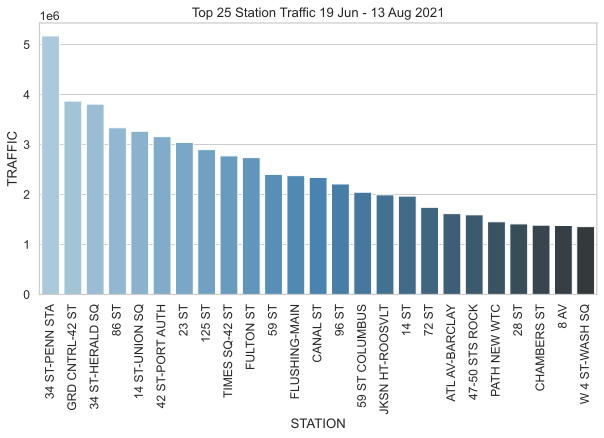

In [144]:
plt.figure(figsize=[10,5])
plt.title('Top 25 Station Traffic 19 Jun - 13 Aug 2021')
plt.xticks(rotation='vertical')

sns.barplot(x='STATION',y='TRAFFIC',data=station_traffic, palette='Blues_d'); 
plt.savefig('top_25.png')

By individual station location

In [145]:
mask4 = mta_df_daily['STATION'] == '34 ST-PENN STA'
stn_view = mta_df_daily[mask4].groupby(['UNIT']).TRAFFIC.sum().reset_index()
stn_view

,UNIT,TRAFFIC
0,R012,1839527
1,R013,840922
2,R031,910752
3,R293,1581483


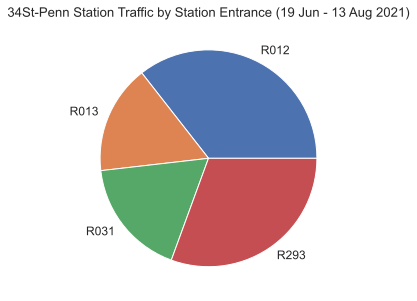

In [147]:
plt.figure(figsize=[5,5])
plt.title('34St-Penn Station Traffic by Station Entrance (19 Jun - 13 Aug 2021)')
plt.pie(stn_view['TRAFFIC'],labels=['R012','R013','R031','R293']);
plt.savefig('penn_entrance.png')

By individual station over time.

In [148]:
stn_view = mta_df_daily[mask4].groupby(['STATION','DATE']).TRAFFIC.sum().reset_index()
stn_view

,STATION,DATE,TRAFFIC
0,34 ST-PENN STA,06/19/2021,63240
1,34 ST-PENN STA,06/20/2021,65048
2,34 ST-PENN STA,06/21/2021,97279
3,34 ST-PENN STA,06/22/2021,102370
4,34 ST-PENN STA,06/23/2021,106395
5,34 ST-PENN STA,06/24/2021,107345
6,34 ST-PENN STA,06/25/2021,107848
7,34 ST-PENN STA,06/26/2021,72952
8,34 ST-PENN STA,06/27/2021,70390
9,34 ST-PENN STA,06/28/2021,100053


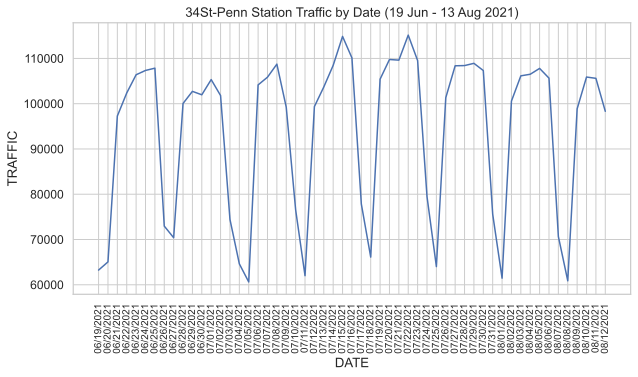

In [135]:
plt.figure(figsize=[10,5])
plt.title('34St-Penn Station Traffic by Date (19 Jun - 13 Aug 2021)')
plt.xticks(rotation='vertical', fontsize='10')
# plt.axis(['06/18/2021', '08/13/2021', 60000, 120000]); 
sns.lineplot(x='DATE',y='TRAFFIC',data=stn_view, palette='Blues_d'); 
plt.savefig('penn_date.png') 